In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from statistics import mean
import re
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import lightgbm as lgb


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
#importing datasets
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Numerical and categorical columns

In [3]:
#drop id columns
train = train.drop('PassengerId', axis = 1)
test = test.drop('PassengerId', axis = 1)

train_features = train.drop('Survived', axis = 1)
train_dependent = train['Survived']

numerical_cols = []
categorical_cols = []
for col in train_features.columns:
    if train_features[col].dtype in  ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical_cols.append(col)
    elif train_features[col].dtype == object:
        categorical_cols.append(col)
        
columns = numerical_cols + categorical_cols
train_features = train_features[columns]
test = test[columns]

print(train_features.columns, train_features.shape)
print(train_dependent.shape)
print(test.columns, test.shape)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name', 'Sex', 'Ticket',
       'Cabin', 'Embarked'],
      dtype='object') (891, 10)
(891,)
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name', 'Sex', 'Ticket',
       'Cabin', 'Embarked'],
      dtype='object') (418, 10)


In [4]:
#merge train_features and test
features = pd.concat([train_features, test], axis = 0)
features.dtypes

Pclass        int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Name         object
Sex          object
Ticket       object
Cabin        object
Embarked     object
dtype: object

## Null Values

### Numerical columns

In [5]:
null = features[numerical_cols].isna().sum().sort_values(ascending = False)
null

Age       263
Fare        1
Parch       0
SibSp       0
Pclass      0
dtype: int64

In [6]:
#imputing missing values in the age column w/the mean.
x = features.iloc[:, 1].values
x = x.reshape(-1,1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x)
x = imputer.transform(x)
features.iloc[:, 1] = x

In [7]:
#handling null fare values
#Check the row with null Fare Value since its only one record
features[features["Fare"].isnull()]

,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked
152,3,60.5,0,0,NaN,"Storey, Mr. Thomas",male,3701,NaN,S


In [8]:
#check for Fare prices for passengers in 3rd class who embarked from Southampton.
for a,b,c in zip(features["Fare"], features["Pclass"], features["Embarked"]):
    if b == 3 and c == "S":
        fare = a

#find the average fare for these passengers
class_3_list = [fare]
m = mean(class_3_list)

#replace the nan with this average
features["Fare"].fillna(m, inplace = True) 

### Categorical columns

In [9]:
null = features[categorical_cols].isnull().sum().sort_values(ascending = False)
null

Cabin       1014
Embarked       2
Ticket         0
Sex            0
Name           0
dtype: int64

In [10]:
#dealing w/missing cabin data in both datasets
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

features['Cabin'] = features['Cabin'].fillna("U0")
features['Deck'] = features['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
features['Deck'] = features['Deck'].map(deck)
features['Deck'] = features['Deck'].fillna(0)
features['Deck'] = features['Deck'].astype(int)
features = features.drop(['Cabin'], axis=1)

In [11]:
#imputing null values in Embarked column w/the value with highest frequency.
y = features.iloc[:, -1].values
y = y.reshape(-1,1)
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(y)
y = imputer.transform(y)
features.iloc[:, -1] = y

In [12]:
features.isna().any()

Pclass      False
Age         False
SibSp       False
Parch       False
Fare        False
Name        False
Sex         False
Ticket      False
Embarked     True
Deck        False
dtype: bool

#### Transforming 'Name' column

In [13]:
#handling the name column
titles = {"Mr": 0, "Mrs": 1, "Miss": 2, "Master": 3, "Rare": 4}

# extract titles
features['Title'] = features.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# replace titles with a more common title or as Rare
features['Title'] = features['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                        'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
features['Title'] = features['Title'].replace('Mlle', 'Miss')
features['Title'] = features['Title'].replace('Ms', 'Miss')
features['Title'] = features['Title'].replace('Mme', 'Mrs')

# convert titles into numbers
features['Title'] = features['Title'].map(titles)

# filling NaN with 0, to get safe
features['Title'] = features['Title'].fillna(0)

features = features.drop(['Name'], axis=1)

### creating Age groups

In [14]:
#creating categories
#age
features['Age'] = features['Age'].astype(int)
features.loc[ features['Age'] <= 11, 'Age'] = 0
features.loc[(features['Age'] > 11) & (features['Age'] <= 18), 'Age'] = 1
features.loc[(features['Age'] > 18) & (features['Age'] <= 22), 'Age'] = 2
features.loc[(features['Age'] > 22) & (features['Age'] <= 27), 'Age'] = 3
features.loc[(features['Age'] > 27) & (features['Age'] <= 33), 'Age'] = 4
features.loc[(features['Age'] > 33) & (features['Age'] <= 40), 'Age'] = 5
features.loc[(features['Age'] > 40) & (features['Age'] <= 66), 'Age'] = 6
features.loc[ features['Age'] > 66, 'Age'] = 7
features['Age'] = features['Age'].astype(int)

In [15]:
train_dependent.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### Feature Generation

In [16]:
features['Age_Class']= features['Age'] * features['Pclass']
features['Fare_Class']= features['Fare'] * features['Pclass']
features = features.drop(['Ticket'], axis=1)
features.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked', 'Deck',
       'Title', 'Age_Class', 'Fare_Class'],
      dtype='object')

In [17]:
# def ticket_clean():

#     global combined

#     # A function that extracts each prefix of the ticket, returns 'Unknown' if no prefix (i.e the ticket is a digit)
#     def cleanTicket(ticket):
#         ticket = ticket.replace('.', '')
#         ticket = ticket.replace('/', '')
#         ticket = ticket.split()
#         ticket = map(lambda t: t.strip(), ticket)
#         ticket = list(filter(lambda t: not t.isdigit(), ticket))
#         if len(ticket) > 0:
#             return ticket[0]
#         else:
#             return 'Unknown'

#     # Extracting dummy variables from tickets:

#     features['Ticket'] = features['Ticket'].map(cleanTicket)
#     tickets_dummies = pd.get_dummies(features['Ticket'], prefix='Ticket')
#     features = pd.concat([features, tickets_dummies], axis=1)
#     features.drop('Ticket', inplace=True, axis=1)

#     status('Ticket')
#     return features

# features = ticket_clean()

## Skewness

In [18]:
# numerical variables
skew_features = features[numerical_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features

There are 3 numerical features with Skew > 0.5 :


Fare      4.364205
SibSp     3.839814
Parch     3.664872
Age      -0.417598
Pclass   -0.597961
dtype: float64

In [19]:
# Normalize skewed features with boxcox transformation
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

## Multicolinearity

In [20]:
#defining numerical features again to include the added features for the correlation plot to be plotted.
numerical_cols= []
for column in train_features.columns:
    if train_features[column].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical_cols.append(column)

new_train_set = pd.concat([features.iloc[:len(train_dependent), :], train_dependent], axis=1)

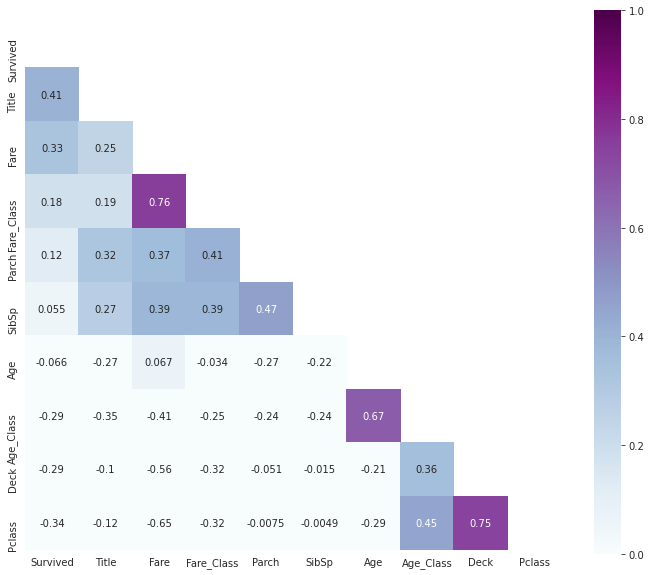

In [21]:
def correlation_map(f_data, f_feature, f_number):
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(12, 10))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

correlation_map(new_train_set, 'Survived', 20)

Good enough

## Encoding categorical variables

In [22]:
features = pd.get_dummies(features).reset_index(drop=True)
features.shape

(1309, 14)

### Dropping columns with 0 predominant values

In [23]:
features_to_be_dropped = []
for feature in features.columns:
    all_value_counts = features[feature].value_counts()
    zero_value_counts = all_value_counts.iloc[0]
    if zero_value_counts / len(features) > 0.995:
        features_to_be_dropped.append(feature)
print('\nFeatures with predominant zeroes:\n')
print(features_to_be_dropped)

features = features.drop(features_to_be_dropped, axis=1).copy()
features.shape


Features with predominant zeroes:

[]


(1309, 14)

No columns was dropped.

## Reconstructing train and test sets

In [24]:
x_train = features.iloc[:len(train_dependent), :]
x_test = features.iloc[len(train_dependent):, :]
y_train = train_dependent
train_set = pd.concat([x_train, y_train], axis=1)

In [25]:
print('train features:', x_train.shape)
print('train target:', y_train.shape)
print('test features:', x_test.shape)
print('train set:', train_set.shape)

train features: (891, 14)
train target: (891,)
test features: (418, 14)
train set: (891, 15)


## Fitting & Predicting ~ XGBoostClassifier

In [26]:
xg = xgb.XGBClassifier(
    n_estimators=2800,
    min_child_weight=0.1,
    learning_rate=0.002,
    max_depth=2,
    subsample=0.47,
    colsample_bytree=0.35,
    gamma=0.4,
    reg_lambda=0.4,
    random_state=42,
    n_jobs=-1,
)

xg.fit(x_train, y_train, eval_metric='auc')
y_pred = xg.predict(x_test)

In [27]:
y_pred.shape

(418,)

## Submission File

In [28]:
new_id = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
submission_id = list(new_id['PassengerId'])

In [29]:
predicted_survived = list(y_pred)

new_id = test.iloc[:, 0]
file = pd.DataFrame({'PassengerId':submission_id, 'Survived': predicted_survived})
submission = file.set_index('PassengerId')
submission.to_csv('sub.csv')
